In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

# Import the s4 model path
import sys
sys.path.append('C:/Users/poomc/Development/s4')
from models.s4.s4 import S4Block as S4
from models.s4.s4d import S4D

from numpy import genfromtxt
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

CUDA extension for structured kernels (Cauchy and Vandermonde multiplication) not found. Install by going to extensions/kernels/ and running `python setup.py install`, for improved speed and memory efficiency. Note that the kernel changed for state-spaces 4.0 and must be recompiled.
Falling back on slow Cauchy and Vandermonde kernel. Install at least one of pykeops or the CUDA extension for better speed and memory efficiency.


In [2]:
# Torch device configuration
device = (
    "cuda" if torch.cuda.is_available() else "mps"
    if torch.backends.mps.is_available() else "cpu"
)
print(f"Using {device} device")
if torch.cuda.is_available():
    print(f"Current GPU device: {torch.cuda.get_device_name(device)}")

Using cuda device
Current GPU device: NVIDIA GeForce RTX 3080


## Load the data

In [3]:
project_path = "C:/Users/poomc/Development/light-har"

# Load Data
x = genfromtxt(project_path+'/data/WISDM_x.csv', delimiter=',')
y = pd.read_csv(project_path+'/data/WISDM_y.csv').values.flatten()

In [4]:
def get_dataloader(x, y, seq_length=16, overlap=0.5, batch_size=32):
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)

    # Function to create time series dataset
    def create_series(x, y, timestep, overlap):
        slide_step = int(timestep * (1 - overlap))
        data_num = int((len(x) / slide_step) - 1)
        dataset = np.ndarray(shape=(data_num, timestep, x.shape[1]))
        labels = []

        for i in range(data_num):
            labels.append(y[slide_step * (i + 1) - 1])
            for j in range(timestep):
                dataset[i, j, :] = x[slide_step * i + j, :]

        return dataset, np.array(labels)


    X_series, y_series = create_series(x, y_encoded, seq_length, overlap)

    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_series, y_series, test_size=0.2, random_state=42)

    # Convert to PyTorch tensors
    x_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create a DataLoader
    train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size, shuffle=False)
    test_dataset = TensorDataset(x_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size, shuffle=True)

    return train_loader, test_loader

## Construct the models

In [5]:
class S4Model(nn.Module):
    def __init__(
        self,
        d_input,
        d_output,
        d_model,
        n_layers=4,
        dropout=0.2,
        lr=0.001,
        dropout_fn=nn.Dropout,
        prenorm=False,
    ):
        super().__init__()

        self.prenorm = prenorm

        # Linear encoder (d_input = 1 for grayscale and 3 for RGB)
        self.encoder = nn.Linear(d_input, d_model)

        # Stack S4 layers as residual blocks
        self.s4_layers = nn.ModuleList()
        self.norms = nn.ModuleList()
        self.dropouts = nn.ModuleList()
        for _ in range(n_layers):
            self.s4_layers.append(
                S4D(d_model, dropout=dropout, transposed=True, lr=lr)
            )
            self.norms.append(nn.LayerNorm(d_model))
            self.dropouts.append(dropout_fn(dropout))

        # Linear decoder
        self.decoder = nn.Linear(d_model, d_output)

    def forward(self, x):
        """
        Input x is shape (B, L, d_input)
        """
        x = self.encoder(x)  # (B, L, d_input) -> (B, L, d_model)

        x = x.transpose(-1, -2)  # (B, L, d_model) -> (B, d_model, L)
        for layer, norm, dropout in zip(self.s4_layers, self.norms, self.dropouts):
            # Each iteration of this loop will map (B, d_model, L) -> (B, d_model, L)

            z = x
            if self.prenorm:
                # Prenorm
                z = norm(z.transpose(-1, -2)).transpose(-1, -2)

            # Apply S4 block: we ignore the state input and output
            z, _ = layer(z)

            # Dropout on the output of the S4 block
            z = dropout(z)

            # Residual connection
            x = z + x

            if not self.prenorm:
                # Postnorm
                x = norm(x.transpose(-1, -2)).transpose(-1, -2)

        x = x.transpose(-1, -2)

        # Pooling: average pooling over the sequence length
        x = x.mean(dim=1)

        # Decode the outputs
        x = self.decoder(x)  # (B, d_model) -> (B, d_output)

        return x

In [6]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(LSTMNet, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.lstm1 = nn.LSTM(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.lstm2 = nn.LSTM(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        
        # First LSTM layer
        out, _ = self.lstm1(x, (h0, c0))
        out = self.dropout1(out)
        
        # Second LSTM layer
        h1 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)
        c1 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)
        out, _ = self.lstm2(out, (h1, c1))
        out = self.dropout2(out)

        # Dense layer
        out = self.fc(out[:, -1, :]) # Taking the last time step
        return out

In [7]:
class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(GRUNet, self).__init__()
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2

        self.gru1 = nn.GRU(input_size, hidden_size1, batch_first=True)
        self.dropout1 = nn.Dropout(0.2)
        self.gru2 = nn.GRU(hidden_size1, hidden_size2, batch_first=True)
        self.dropout2 = nn.Dropout(0.2)
        self.fc = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size1).to(x.device)
        
        # First GRU layer
        out, _ = self.gru1(x, h0)
        out = self.dropout1(out)
        
        # Second GRU layer
        h1 = torch.zeros(1, x.size(0), self.hidden_size2).to(x.device)
        out, _ = self.gru2(out, h1)
        out = self.dropout2(out)

        # Dense layer
        out = self.fc(out[:, -1, :])  # Taking the last time step
        return out

## Training

In [34]:
import pandas as pd
from trainer import train, validate, plot_or_save_metrics
import matplotlib.pyplot as plt
import copy

def find_optimal_timestep(model, project_path, x, y, name='unnamed', num_epochs=1):
    """
    Find the optimal timestep for a given model by training on different sequence lengths.

    Parameters:
    - model: The model to be experimented.
    - name: A name identifier for the model.
    - num_epochs: Number of epochs to train the model.
    - project_path: Path to the project directory.
    - x: Input data.
    - y: Target data.

    Returns:
    - best_model: The trained model with the best accuracy.
    - best_accuracy: The accuracy achieved by the best model.
    """

    # Define the sequence lengths to experiment with
    seq_lengths = [4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 48, 56, 64, 72, 80, 88, 96, 112, 128, 152, 160, 180, 200, 220, 256]

    # Initialize variables to keep track of the best model and accuracy
    accuracies = []
    best_model = None
    best_accuracy = 0
    best_timestep = 0

    for length in seq_lengths:
        # Create a new model for each sequence length
        current_model = copy.deepcopy(model)

        # Get data loaders for the current sequence length
        train_loader, test_loader = get_dataloader(x, y, seq_length=length)

        # Define paths for saving results
        working_dir = project_path + "/code/s4/models/timestep_optimization"

        # Train the model and validate
        train_losses, val_losses, val_accuracies = train(current_model, 
                                                          train_loader, 
                                                          test_loader, 
                                                          num_epochs=num_epochs, 
                                                          verbose=0)

        loss, acc = validate(current_model, test_loader, device='cpu')

        # Update best model if current accuracy is higher
        if acc > best_accuracy:
            best_accuracy = acc
            best_model = current_model
            best_timestep = length
            # Save training history to a DataFrame
            history_df = pd.DataFrame({
                'epoch': range(1, num_epochs + 1),
                'train_loss': train_losses,
                'val_loss': val_losses,
                'val_accuracy': val_accuracies
            })

        accuracies.append(acc)
        print(f"Seg length: {length}, test acc = {acc:.2f}%")

    # Save the training history to a CSV file
    history_df.to_csv(f"{working_dir}/{name}_seq{best_timestep}_hist.csv", index=False)

    # Save the plot
    plot_or_save_metrics(num_epochs, 
                         history_df['train_loss'], 
                         history_df['val_loss'], 
                         history_df['val_accuracy'],
                         show_plot=False,
                         save_path=f"{working_dir}/best_model_{name}_seq{best_timestep}")

    # Print the best timestep
    print(f"Best Timestep: {best_timestep} with accuracy of {best_accuracy:.2f}%")

    # Save the best model's state dictionary
    torch.save(best_model.state_dict(), f"{working_dir}/best_model_{name}_seq{best_timestep}.pt")

    # Create a DataFrame from the accuracies list
    df = pd.DataFrame({"Seq Length": seq_lengths, "Accuracy": accuracies})

    # Save the DataFrame to a CSV file
    csv_filename = f"{working_dir}/{name}-accuracies.csv"
    df.to_csv(csv_filename, index=False)

In [35]:
model = S4Model(d_input=3, d_output=6, d_model=16)
find_optimal_timestep(model, project_path, x, y, name='s4', num_epochs=30)

Seg length: 4, test acc = 77.20%
Seg length: 8, test acc = 84.48%
Seg length: 12, test acc = 89.32%
Seg length: 16, test acc = 91.49%
Seg length: 20, test acc = 93.67%
Seg length: 24, test acc = 94.54%
Seg length: 28, test acc = 94.91%
Seg length: 32, test acc = 94.08%
Seg length: 36, test acc = 95.39%
Seg length: 40, test acc = 95.68%
Seg length: 48, test acc = 95.37%
Seg length: 56, test acc = 96.32%
Seg length: 64, test acc = 95.18%
Seg length: 72, test acc = 96.31%
Seg length: 80, test acc = 96.68%
Seg length: 88, test acc = 95.99%
Seg length: 96, test acc = 95.90%
Seg length: 112, test acc = 96.42%
Seg length: 128, test acc = 96.03%
Seg length: 152, test acc = 96.12%
Seg length: 160, test acc = 96.61%
Seg length: 256, test acc = 94.14%
Best Timestep: 80 with accuracy of 96.68%


In [36]:
model = LSTMNet(input_size=3, hidden_size1=50, hidden_size2=25, output_size=6)
find_optimal_timestep(model, project_path, x, y, name='lstm', num_epochs=30)

Seg length: 4, test acc = 82.74%
Seg length: 8, test acc = 91.01%
Seg length: 12, test acc = 93.75%
Seg length: 16, test acc = 95.30%
Seg length: 20, test acc = 96.23%
Seg length: 24, test acc = 96.72%
Seg length: 28, test acc = 96.74%
Seg length: 32, test acc = 96.93%
Seg length: 36, test acc = 97.10%
Seg length: 40, test acc = 97.15%
Seg length: 48, test acc = 97.85%
Seg length: 56, test acc = 98.00%
Seg length: 64, test acc = 97.56%
Seg length: 72, test acc = 97.12%
Seg length: 80, test acc = 97.83%
Seg length: 88, test acc = 98.07%
Seg length: 96, test acc = 96.89%
Seg length: 112, test acc = 97.44%
Seg length: 128, test acc = 97.19%
Seg length: 152, test acc = 96.96%
Seg length: 160, test acc = 92.72%
Seg length: 256, test acc = 92.06%
Best Timestep: 88 with accuracy of 98.07%


In [37]:
model = GRUNet(input_size=3, hidden_size1=50, hidden_size2=25, output_size=6)
find_optimal_timestep(model, project_path, x, y, name='gru', num_epochs=30)

Seg length: 4, test acc = 81.77%
Seg length: 8, test acc = 90.15%
Seg length: 12, test acc = 93.41%
Seg length: 16, test acc = 94.95%
Seg length: 20, test acc = 95.18%
Seg length: 24, test acc = 96.23%
Seg length: 28, test acc = 96.70%
Seg length: 32, test acc = 96.94%
Seg length: 36, test acc = 97.25%
Seg length: 40, test acc = 97.02%
Seg length: 48, test acc = 97.23%
Seg length: 56, test acc = 97.53%
Seg length: 64, test acc = 97.79%
Seg length: 72, test acc = 97.32%
Seg length: 80, test acc = 97.73%
Seg length: 88, test acc = 98.24%
Seg length: 96, test acc = 97.07%
Seg length: 112, test acc = 98.58%
Seg length: 128, test acc = 97.86%
Seg length: 152, test acc = 97.86%
Seg length: 160, test acc = 96.87%
Seg length: 256, test acc = 95.42%
Best Timestep: 112 with accuracy of 98.58%


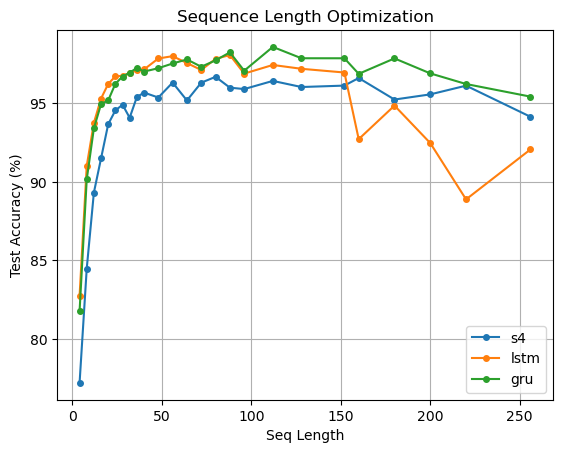

In [69]:
for name in ['s4', 'lstm', 'gru']:
    working_dir = project_path+"/code/s4/models/timestep_optimization"
    df = pd.read_csv(working_dir+f"/{name}-accuracies.csv")
    plt.plot(df['Seq Length'], df['Accuracy'], label=name, marker='o', markersize=4)

plt.title("Sequence Length Optimization")
plt.xlabel("Seq Length")
plt.ylabel("Test Accuracy (%)")
plt.legend()
plt.grid()
plt.show()

## Let the GRU train longer at 112 seq.

In [71]:
model = GRUNet(input_size=3, hidden_size1=50, hidden_size2=25, output_size=6)
train_loader, test_loader = get_dataloader(x, y, seq_length=112)
train_losses, val_losses, val_accuracies = train(model, train_loader, test_loader, save_path=working_dir+f"/gru-optimized", num_epochs=100)

Epoch [1/100], Train Loss: 0.7622, Val Accuracy: 82.59%
Epoch [2/100], Train Loss: 0.4155, Val Accuracy: 86.84%
Epoch [3/100], Train Loss: 0.3146, Val Accuracy: 88.81%
Epoch [4/100], Train Loss: 0.2602, Val Accuracy: 91.11%
Epoch [5/100], Train Loss: 0.2224, Val Accuracy: 92.76%
Epoch [6/100], Train Loss: 0.1865, Val Accuracy: 94.53%
Epoch [7/100], Train Loss: 0.1591, Val Accuracy: 95.65%
Epoch [8/100], Train Loss: 0.1295, Val Accuracy: 96.74%
Epoch [9/100], Train Loss: 0.1062, Val Accuracy: 96.82%
Epoch [10/100], Train Loss: 0.0988, Val Accuracy: 97.17%
Epoch [11/100], Train Loss: 0.0850, Val Accuracy: 96.29%
Epoch [12/100], Train Loss: 0.0762, Val Accuracy: 97.25%
Epoch [13/100], Train Loss: 0.0691, Val Accuracy: 97.30%
Epoch [14/100], Train Loss: 0.0634, Val Accuracy: 96.93%
Epoch [15/100], Train Loss: 0.0564, Val Accuracy: 96.88%
Epoch [16/100], Train Loss: 0.0515, Val Accuracy: 97.78%
Epoch [17/100], Train Loss: 0.0518, Val Accuracy: 97.65%
Epoch [18/100], Train Loss: 0.0438, Val 

In [77]:
loss, acc = validate(model, test_loader, device='cpu')
print(f"Test loss = {loss:.6f}, Test accuracy = {acc:.2f}%")

Test loss = 0.065735, Test accuracy = 98.50%


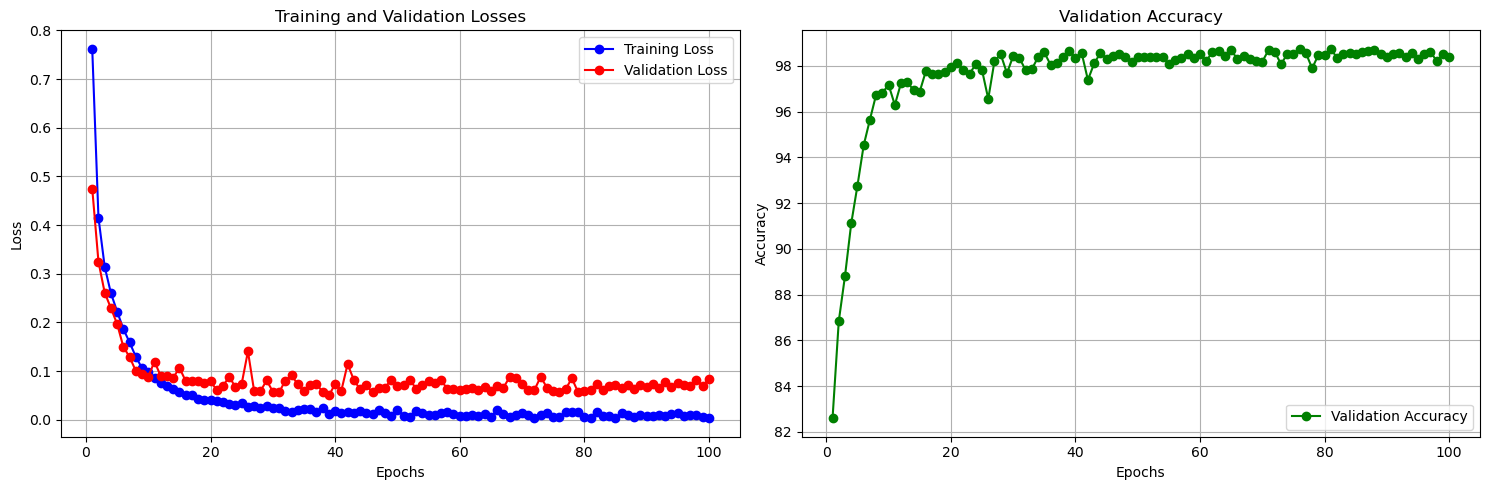

In [78]:
plot_or_save_metrics(100, train_losses, val_losses, val_accuracies)